<a href="https://colab.research.google.com/github/KOYAMA-Yuya/numerical_analysis/blob/main/5_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ニューラルネットワーク

## Googleドライブをマウントする

Googleドライブ内のデータセットを読みこむためにサーバーにGoogleドライブをマウントする

必ず切断のたびに行うこと

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### カレントディレクトリを移動

In [ ]:
cd drive

/content/drive


In [ ]:
cd MyDrive

/content/drive/MyDrive


In [ ]:
cd mnist

/content/drive/MyDrive/mnist


### `ls`で中身を確認

In [ ]:
ls

common/  dataset/  sample_weight.pkl


`common/  dataset/  sample_weight.pkl`

が入っていることを確認して次に進む

## 手書き文字認識

まずは用意された重み学習済みのサンプルデータを使って文字認識を行う

### データセットの読み込み

In [ ]:
import sys, os
sys.path.append(os.pardir) # 親ディレクトリのファイルをインポートするための設定
from dataset.mnist import load_mnist

In [ ]:
(x_train, t_train), (x_test, t_test) = load_mnist(flatten = True, normalize = False)

学習データとテストデータの内訳を確認

In [ ]:
print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


### データを整形して中身を見る

データセットの中身を確認するために画像形式で表示させてみる

In [ ]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist
from PIL import Image
from IPython.display import display

def img_show(img):
  pil_img = Image.fromarray(np.uint8(img))
  display(pil_img)

(x_train, t_train), (x_test, t_test) = load_mnist(flatten = True, normalize = False)

img = x_train[0]
label = t_train[0]

print("表示される数字のラベル：", label)
print("整形前のデータの形式：", img.shape)
img = img.reshape(28, 28)
print("整形後のデータの形式：", img.shape)

img_show(img)

表示される数字のラベル： 5
整形前のデータの形式： (784,)
整形後のデータの形式： (28, 28)


### サンプルデータを読み込む

事前に重みの学習を済ませたモデルを読み込み，手書き文字認識を行う

データ読み込み用の関数`getdata()`, `init_network()`と認識用の関数`predict(network, x)`を定義

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import pickle
from dataset.mnist import load_mnist
from common.functions import *

In [ ]:
def get_data():
    # データセットからテストデータを読み込む
    (x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, flatten=True, one_hot_label=False)
    return x_test, t_test

In [ ]:
def init_network():
    # 学習済みのサンプルデータを読み込む
    with open("sample_weight.pkl", 'rb') as f:
        network = pickle.load(f)
    return network

In [ ]:
def predict(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']

    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    a3 = np.dot(z2, W3) + b3
    y = softmax(a3)

    return y

### 認識と認識率の確認

サンプルデータでの認識率が表示される

In [ ]:
x, t = get_data() # MNISTデータを取得（x:画像データ，t:教師データ）
network = init_network() # ネットワークを生成
accuracy_cnt = 0
for i in range(len(x)): # 全ての画像データをfor文で処理にかける
    y = predict(network, x[i]) # ニューラルネットワークを通して予測した結果を得る（最後の出力はsoftmaxのため確率）
    p = np.argmax(y) # 最も確率の高い要素のインデックスを取得
    if p == t[i]: # 最も確率が高いと予測した数字と教師データが同じか確認
        accuracy_cnt += 1 # 同じ場合はカウントを1増やす

print("Accuracy:" + str(float(accuracy_cnt) / len(x)))

Accuracy:0.9352


## 損失関数

### 2乗和誤差

各要素の差の2乗を計算してその総和を算出

In [ ]:
def mean_squared_error(y, t):
  return 0.5 * np.sum((y - t) ** 2)

y:ニューラルネットワークの出力

t:教師データ

In [ ]:
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
mean_squared_error(np.array(y), np.array(t))

0.09750000000000003

正解から外れると大きくなる

In [ ]:
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]

In [ ]:
mean_squared_error(np.array(y), np.array(t))

0.5975

### 交差エントロピー誤差

正解ラベルの出力結果だけ参照する

In [ ]:
def cross_entropy_error(y, t):
  delta = 1e-7 #すごい小さい数
  return -np.sum(t * np.log(y + delta))

In [ ]:
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
cross_entropy_error(np.array(y), np.array(t))

0.510825457099338

In [ ]:
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]

In [ ]:
cross_entropy_error(np.array(y), np.array(t))

2.302584092994546

## ミニバッチ学習

訓練データ全体からデータを無作為選ぶ仕組みを実装する

In [ ]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist

In [ ]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True, one_hot_label = True)
print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


In [ ]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

In [ ]:
np.random.choice(60000, 10)

array([ 8546, 35626, 53816, 30754, 23468, 44154, 39641, 22699, 33935,
       20379])

ミニバッチ学習に合わせて損失関数を更新

In [ ]:
def cross_entropy_error(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)

  batch_size = y.shape[0]
  return -np.sum(t * np.log(y + 1e-7)) / batch_size

In [ ]:
def cross_entropy_error(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)

  # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
  if t.size == y.size:
    t = t.argmax(axis=1)

  batch_size = y.shape[0]
  return -np.sum(np.log(y[np.arrange(batch_size), t] + 1e-7)) / batch_size

## 勾配法

関数の定義

In [ ]:
def function_1(x):
  return x[0] ** 2 + x[1] ** 2

勾配を求める

In [ ]:
def numerical_gradient(f, x):
  h = 1e-4 # 0.0001
  grad = np.zeros_like(x) # xと同じ形状の配列を生成

  for idx in range(x.size):
    tmp_val = x[idx]
    # f(x+h)の計算
    x[idx] = tmp_val + h
    fxh1 = f(x)

    # f(x-h)の計算
    x[idx] = tmp_val - h
    fxh2 = f(x)

    grad[idx] = (fxh1 - fxh2) / (2 * h)
    x[idx] = tmp_val # 値を元に戻す

  return grad

In [ ]:
numerical_gradient(function_1, np.array([3.0, 4.0]))

array([6., 8.])

In [ ]:
numerical_gradient(function_1, np.array([0.0, 2.0]))

array([0., 4.])

In [ ]:
numerical_gradient(function_1, np.array([3.0, 0.0]))

array([6., 0.])

### 勾配の表示

勾配をグラフとして表示する

メモ内のスライドを参考に書いた

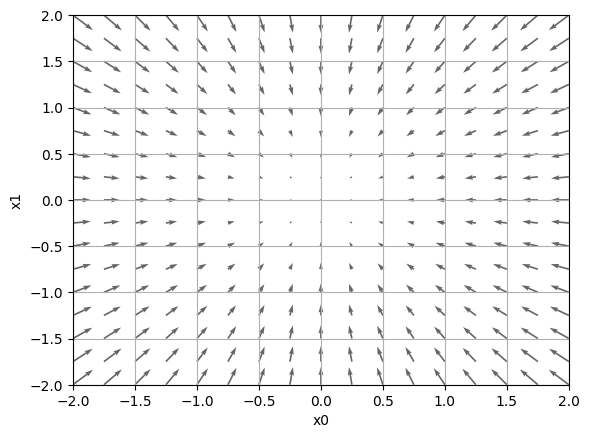

In [ ]:
# coding: utf-8
# cf.http://d.hatena.ne.jp/white_wheels/20100327/p3
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D


def _numerical_gradient_no_batch(f, x):
    h = 1e-4  # 0.0001
    grad = np.zeros_like(x)

    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)  # f(x+h)

        x[idx] = tmp_val - h
        fxh2 = f(x)  # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val  # 値を元に戻す

    return grad


def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)

        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)

        return grad


def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)


def tangent_line(f, x):
    d = numerical_gradient(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y


if __name__ == '__main__':
    x0 = np.arange(-2, 2.5, 0.25)
    x1 = np.arange(-2, 2.5, 0.25)
    X, Y = np.meshgrid(x0, x1)

    X = X.flatten()
    Y = Y.flatten()

    grad = numerical_gradient(function_2, np.array([X, Y]).T).T

    plt.figure()
    plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.grid()
    plt.draw()
    plt.show()


## 2層ニューラルネットワークのクラス

クラスとして二層ニューラルネットワークを実装する

クラスとはざっくりいうと関数と変数の塊をひな型にしたもののこと

それぞれの関数の大まかな内容をコメントアウトでまとめる

In [ ]:
from common.gradient import numerical_gradient
from common.functions import *

class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # この関数はこのクラスが呼び出された（インスタンス化）ときに実行される
        # 重みを入れる変数を用意する
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        # 現在の重みパラメータを使って文字認識する
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']

        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        return y

    # x:入力データ, t:教師データ
    def loss(self, x, t):
        # 損失関数を利用してlossを出す
        y = self.predict(x)

        return cross_entropy_error(y, t)

    def accuracy(self, x, t):
        # 正答率を出す
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        # 微分を使って勾配を出す
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

    def gradient(self, x, t):
        # 誤差伝播法を使って勾配を出す
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}

        batch_num = x.shape[0]

        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)

        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads

データセットを用意する

In [ ]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True, one_hot_label = True)
print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


### 学習してみる

実際に学習を回す

In [ ]:
train_size = x_train.shape[0]

# ハイパーパラメータ
iters_num = 10000  # 繰り返しの回数（バッチ数）を適宜設定する
batch_size = 100
learning_rate = 0.1

# 損失と認識率の保管先
train_loss_list = []
train_acc_list = []
test_acc_list = []

# クラスからインスタンスを作成
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 何バッチで何エポックか出す
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # ミニバッチ
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 勾配の計算
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)

    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    # 損失を出す
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    # エポックごとに認識率を記録
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))


train acc, test acc | 0.10441666666666667, 0.1028
train acc, test acc | 0.78755, 0.7942
train acc, test acc | 0.8778333333333334, 0.8818
train acc, test acc | 0.89825, 0.9027
train acc, test acc | 0.9068333333333334, 0.9112
train acc, test acc | 0.9148, 0.9167
train acc, test acc | 0.91905, 0.9219
train acc, test acc | 0.9237666666666666, 0.927
train acc, test acc | 0.9275333333333333, 0.9282
train acc, test acc | 0.9306166666666666, 0.9306
train acc, test acc | 0.9345166666666667, 0.9356
train acc, test acc | 0.9369666666666666, 0.9368
train acc, test acc | 0.9396333333333333, 0.9386
train acc, test acc | 0.9419833333333333, 0.9411
train acc, test acc | 0.94445, 0.9432
train acc, test acc | 0.9451666666666667, 0.9435
train acc, test acc | 0.9471833333333334, 0.9461


### 認識率の表示

学習中に記録したリストからグラフを作成

同様に損失のグラフも作成できる

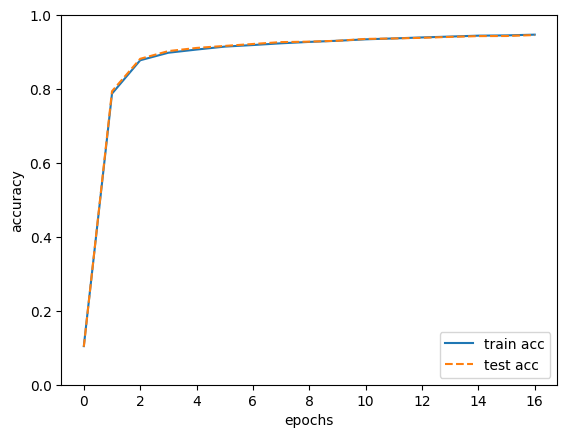

In [ ]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

### 認識させてみる

テストデータの認識例を表示する

改変すれば認識に迷った例のみ出力などもできる

正解 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
判定[ 4 ]
[0] 0.00%
[1] 0.00%
[2] 0.00%
[3] 0.00%
[4] 99.22%
[5] 0.02%
[6] 0.00%
[7] 0.03%
[8] 0.12%
[9] 0.61%


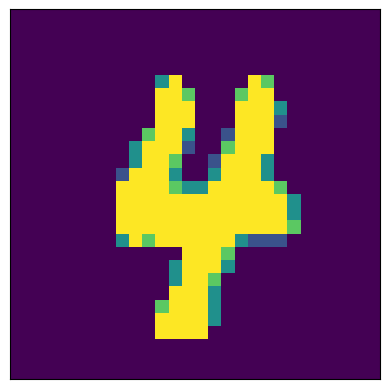

正解 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
判定[ 0 ]
[0] 99.02%
[1] 0.00%
[2] 0.08%
[3] 0.02%
[4] 0.01%
[5] 0.78%
[6] 0.03%
[7] 0.00%
[8] 0.06%
[9] 0.00%


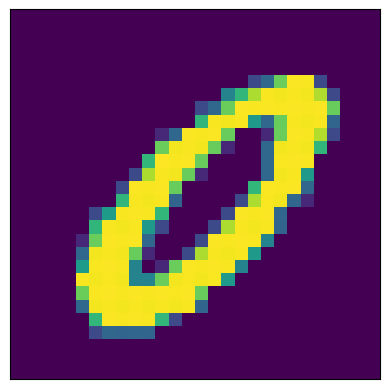

正解 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
判定[ 2 ]
[0] 0.01%
[1] 0.00%
[2] 99.90%
[3] 0.06%
[4] 0.00%
[5] 0.00%
[6] 0.00%
[7] 0.00%
[8] 0.02%
[9] 0.00%


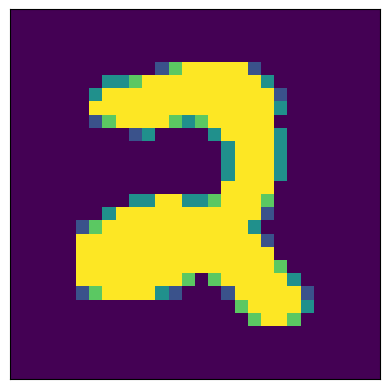

正解 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
判定[ 1 ]
[0] 0.00%
[1] 99.28%
[2] 0.22%
[3] 0.06%
[4] 0.00%
[5] 0.09%
[6] 0.03%
[7] 0.03%
[8] 0.27%
[9] 0.01%


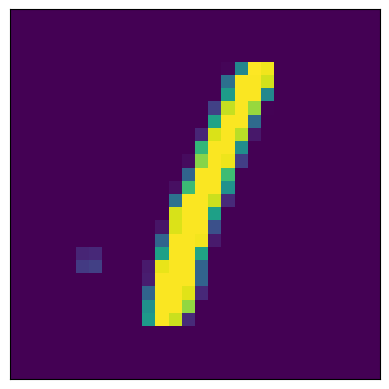

正解 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
判定[ 5 ]
[0] 0.00%
[1] 0.46%
[2] 0.03%
[3] 12.10%
[4] 0.17%
[5] 83.15%
[6] 0.08%
[7] 0.01%
[8] 3.12%
[9] 0.88%


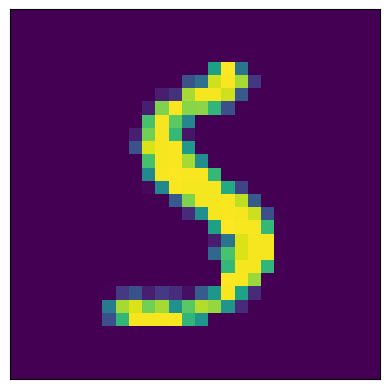

正解 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
判定[ 1 ]
[0] 0.00%
[1] 97.00%
[2] 0.96%
[3] 0.42%
[4] 0.01%
[5] 0.22%
[6] 0.00%
[7] 0.97%
[8] 0.34%
[9] 0.08%


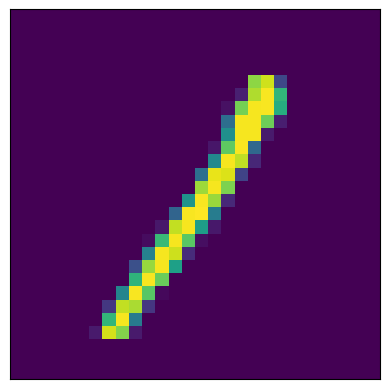

正解 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
判定[ 1 ]
[0] 0.00%
[1] 99.29%
[2] 0.15%
[3] 0.15%
[4] 0.00%
[5] 0.07%
[6] 0.01%
[7] 0.11%
[8] 0.17%
[9] 0.04%


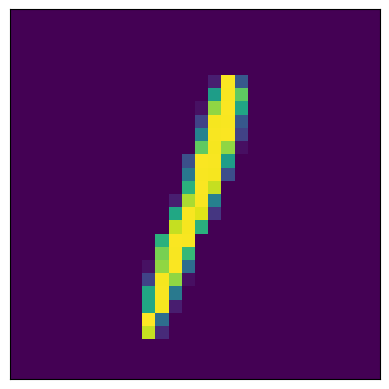

正解 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
判定[ 9 ]
[0] 0.00%
[1] 0.00%
[2] 0.00%
[3] 0.06%
[4] 1.20%
[5] 0.03%
[6] 0.00%
[7] 1.01%
[8] 0.11%
[9] 97.59%


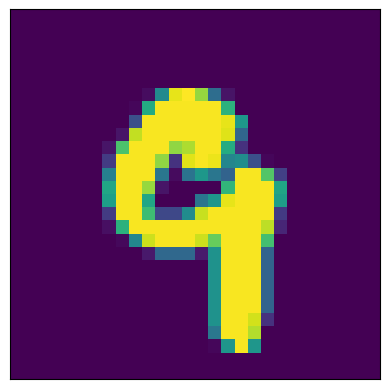

正解 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
判定[ 2 ]
[0] 4.63%
[1] 0.00%
[2] 93.96%
[3] 0.83%
[4] 0.01%
[5] 0.02%
[6] 0.04%
[7] 0.01%
[8] 0.49%
[9] 0.01%


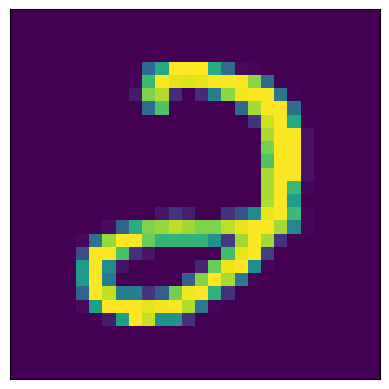

正解 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
判定[ 8 ]
[0] 0.00%
[1] 0.09%
[2] 0.20%
[3] 0.07%
[4] 0.03%
[5] 0.19%
[6] 0.02%
[7] 0.00%
[8] 99.30%
[9] 0.09%


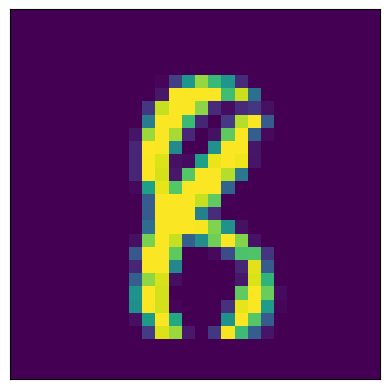

正解 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
判定[ 7 ]
[0] 0.01%
[1] 0.00%
[2] 0.05%
[3] 0.46%
[4] 0.00%
[5] 0.01%
[6] 0.00%
[7] 99.37%
[8] 0.00%
[9] 0.10%


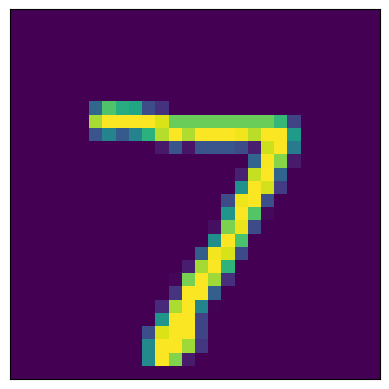

正解 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
判定[ 1 ]
[0] 0.00%
[1] 98.77%
[2] 0.18%
[3] 0.03%
[4] 0.01%
[5] 0.24%
[6] 0.01%
[7] 0.02%
[8] 0.73%
[9] 0.01%


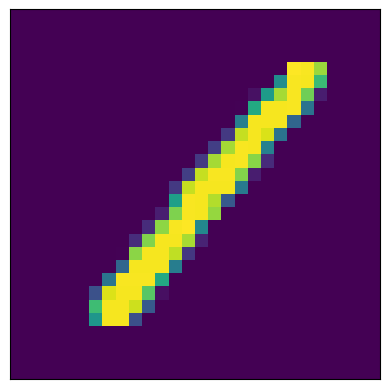

正解 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
判定[ 6 ]
[0] 0.25%
[1] 0.00%
[2] 36.38%
[3] 0.09%
[4] 10.61%
[5] 0.52%
[6] 51.60%
[7] 0.00%
[8] 0.47%
[9] 0.07%


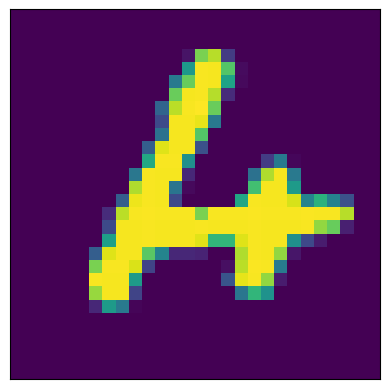

正解 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
判定[ 2 ]
[0] 0.01%
[1] 0.03%
[2] 99.13%
[3] 0.57%
[4] 0.00%
[5] 0.01%
[6] 0.01%
[7] 0.00%
[8] 0.23%
[9] 0.00%


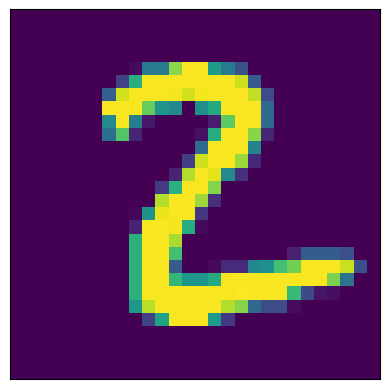

正解 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
判定[ 6 ]
[0] 0.00%
[1] 0.00%
[2] 1.12%
[3] 0.00%
[4] 0.29%
[5] 0.04%
[6] 98.52%
[7] 0.00%
[8] 0.02%
[9] 0.00%


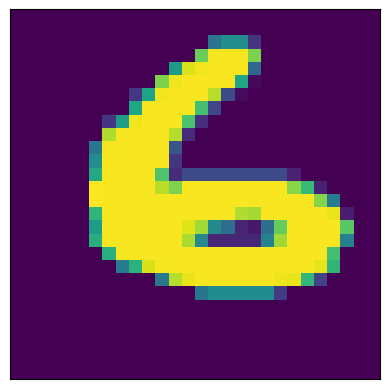

正解 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
判定[ 0 ]
[0] 99.48%
[1] 0.00%
[2] 0.09%
[3] 0.00%
[4] 0.03%
[5] 0.06%
[6] 0.16%
[7] 0.00%
[8] 0.16%
[9] 0.01%


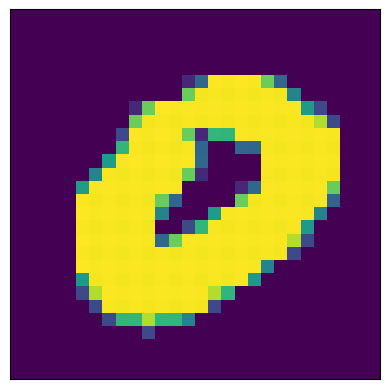

正解 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
判定[ 8 ]
[0] 0.02%
[1] 0.03%
[2] 0.48%
[3] 1.00%
[4] 0.15%
[5] 1.87%
[6] 0.01%
[7] 0.04%
[8] 92.86%
[9] 3.53%


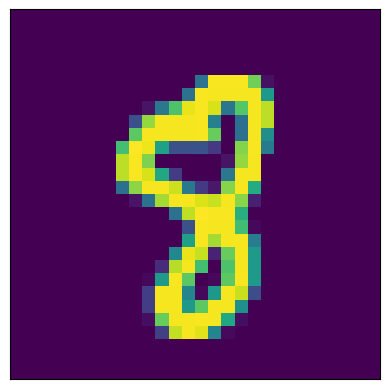

正解 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
判定[ 8 ]
[0] 0.00%
[1] 0.60%
[2] 0.02%
[3] 0.72%
[4] 0.00%
[5] 0.13%
[6] 0.00%
[7] 0.02%
[8] 97.71%
[9] 0.79%


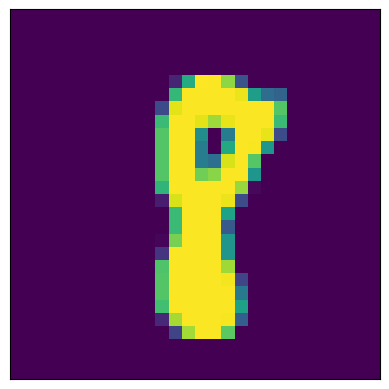

正解 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
判定[ 5 ]
[0] 0.06%
[1] 0.21%
[2] 0.07%
[3] 1.44%
[4] 4.76%
[5] 92.67%
[6] 0.29%
[7] 0.05%
[8] 0.35%
[9] 0.09%


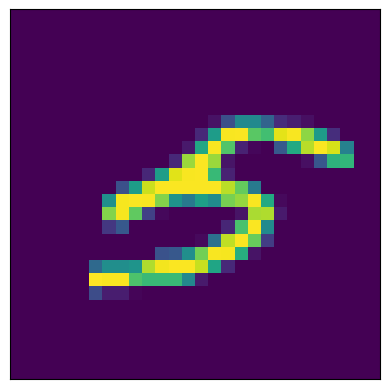

正解 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
判定[ 4 ]
[0] 0.00%
[1] 0.00%
[2] 0.00%
[3] 0.01%
[4] 99.62%
[5] 0.02%
[6] 0.00%
[7] 0.01%
[8] 0.02%
[9] 0.31%


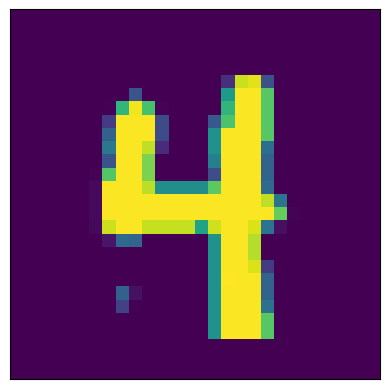

In [ ]:
import matplotlib.pyplot as plt

def showImg(x):
    example = x.reshape((28, 28))
    plt.figure()
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(example)
    plt.show()
    return

test_size = 20
test_mask = np.random.choice(10000, test_size)
x = x_test[test_mask]
t = t_test[test_mask]

for i in range(20):
    y = network.predict(x[i])
    p= np.argmax(y)
    print("正解 " + str(t[i]))
    print("判定[ " + str(p) + " ]")
    count = 0
    for v in y:
        print("["+str(count)+"] {:.2%}".format(v))
        count += 1
    showImg(x[i])